In [1]:
# This library is our indicator that the required installs
# need to be done.
import transformers
import sys
sys.path.append("/juice2/scr2/aryaman/align-transformers/")
print(sys.path)

['/juice2/scr2/aryaman/coref', '/juice2/scr2/aryaman/coref', '/sailhome/aryaman/miniconda3/envs/boundless/lib/python38.zip', '/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.8', '/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.8/lib-dynload', '', '/sailhome/aryaman/miniconda3/envs/boundless/lib/python3.8/site-packages', '/juice2/scr2/aryaman/align-transformers', '/juice2/scr2/aryaman/align-transformers/']


In [156]:
import sys
import torch
sys.path.append("..")

import pandas as pd
from models.utils import embed_to_distrib, top_vals, format_token, sm
from models.configuration_alignable_model import AlignableRepresentationConfig, AlignableConfig
from models.alignable_base import AlignableModel
from models.interventions import VanillaIntervention
from models.gpt_neox.modelings_alignable_gpt_neox import create_gpt_neox

%config InlineBackend.figure_formats = ['svg']
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text, \
                     geom_bar, geom_hline, scale_y_log10, geom_point, geom_label, facet_grid
from plotnine.scales import scale_y_reverse, scale_fill_cmap
from tqdm import tqdm

In [142]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
config, tokenizer, gpt = create_gpt_neox(name="EleutherAI/pythia-1.4b", cache_dir="/nlp/scr/aryaman/.cache/huggingface/hub")
gpt.to(device)

loaded model


GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 2048)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): GPTNeoXLayer(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
          

In [143]:
names = {
    "he": ["John", "Bill", "Joseph", "Patrick", "Ken", "Simon", "Richard", "David", "Michael"],
    "she": ["Sarah", "Mary", "Elizabeth", "Jane"]
}
flattened_names = [(name, gender) for gender in names for name in names[gender] if len(tokenizer.encode(name)) == 1]
flattened_names

[('John', 'he'),
 ('Bill', 'he'),
 ('Joseph', 'he'),
 ('Patrick', 'he'),
 ('Ken', 'he'),
 ('Simon', 'he'),
 ('Richard', 'he'),
 ('David', 'he'),
 ('Michael', 'he'),
 ('Sarah', 'she'),
 ('Mary', 'she'),
 ('Elizabeth', 'she'),
 ('Jane', 'she')]

In [144]:
tokens = tokenizer.encode(" he she")
tokens

[344, 703]

In [145]:
data = []
for name1 in tqdm(flattened_names):
    for name2 in flattened_names:
        for verb in ["betrayed", "hated", "divorced", "amazed"]:
            if name1 == name2: continue
            base = f"{name1[0]} {verb} {name2[0]} because"
            inputs = [
                tokenizer(base, return_tensors="pt").to(device),
            ]
            # print(base)
            res = gpt(**inputs[0])
            logits = sm(res.logits)[0, -1].cpu().detach()
            data.append({
                "name1": name1[0],
                "name2": name2[0],
                "genders": f"{name1[1]}, {name2[1]}",
                "verb": verb,
                "p(_he)": logits[tokens[0]].item(),
                "p(_she)": logits[tokens[1]].item()
            })

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.05s/it]


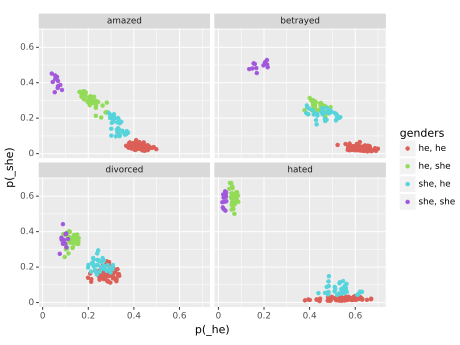

In [146]:
df = pd.DataFrame(data)
plot = (ggplot(df, aes(x='p(_he)', y='p(_she)', color='genders', label='name1')) + geom_point() + facet_wrap("~verb", nrow=2))
print(plot)

In [147]:
def simple_position_config(model_type, layer):
    alignable_config = AlignableConfig(
        alignable_model_type=model_type,
        alignable_representations=[
            AlignableRepresentationConfig(
                layer,             # layer
                "block_output", # intervention type
                "pos",             # intervention unit
                1                  # max number of unit
            ),
        ],
        alignable_interventions_type=VanillaIntervention,
    )
    return alignable_config

In [158]:
data = []

for name1 in names["he"][:2]:
    for namea in names["he"][:2]:
        if name1 == namea: continue
        for name2 in names["she"][:2]:
            tokens = tokenizer.encode(f" he she")
            base = tokenizer(f"{name1} hated {namea} because", return_tensors="pt").to(device)
            sources = [tokenizer(f"{name1} hated {name2} because", return_tensors="pt").to(device)]
            print(f"{name1} hated {namea} because")
            print(f"{name1} hated {name2} because")
            assert base.input_ids.shape == sources[0].input_ids.shape
            for layer_i in tqdm(range(gpt.config.num_hidden_layers)):
                for pos_i in range(4):
                    alignable_config = simple_position_config(type(gpt), layer_i)
                    alignable = AlignableModel(alignable_config, gpt)
                    _, counterfactual_outputs = alignable(
                        base,
                        sources,
                        {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
                    )
                    probs = sm(counterfactual_outputs.logits)[0, -1].cpu().detach()
                    for i, token in enumerate(tokens):
                        data.append({
                            "layer": layer_i,
                            "pos": pos_i,
                            "intervention": f"{name1}, {namea}/{name2}",
                            "prob": probs[token].item(),
                            "token": i
                        })

John hated Bill because
John hated Sarah because


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.10it/s]


John hated Bill because
John hated Mary because


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.11it/s]


Bill hated John because
Bill hated Sarah because


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.12it/s]


Bill hated John because
Bill hated Mary because


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.12it/s]


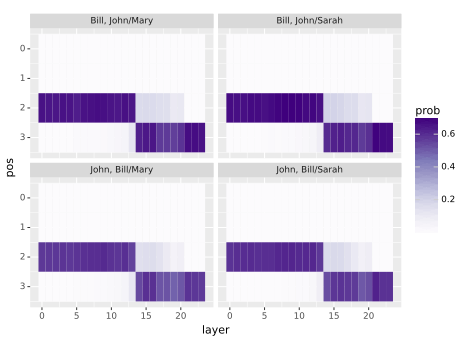

In [161]:
df = pd.DataFrame(data)
df["layer"] = df["layer"].astype(int)
df["pos"] = df["pos"].astype(int)
df["prob"] = df["prob"].astype(float)

plot = (ggplot(df[df["token"] == 1], aes(x="layer", y="pos")) + scale_y_reverse()
        + geom_tile(aes(fill="prob")) + scale_fill_cmap("Purples") + facet_wrap("intervention"))
print(plot)

In [164]:
data = []

for name1 in names["he"][:2]:
    for namea in names["he"][:2]:
        if name1 == namea: continue
        for name2 in names["she"][:2]:
            tokens = tokenizer.encode(f" he she")
            base = tokenizer(f"{name1} amazed {namea} because", return_tensors="pt").to(device)
            sources = [tokenizer(f"{name2} amazed {namea} because", return_tensors="pt").to(device)]
            print(tokenizer.decode(base.input_ids[0]))
            print(tokenizer.decode(sources[0].input_ids[0]))
            assert base.input_ids.shape == sources[0].input_ids.shape
            for layer_i in tqdm(range(gpt.config.num_hidden_layers)):
                for pos_i in range(4):
                    alignable_config = simple_position_config(type(gpt), layer_i)
                    alignable = AlignableModel(alignable_config, gpt)
                    _, counterfactual_outputs = alignable(
                        base,
                        sources,
                        {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
                    )
                    probs = sm(counterfactual_outputs.logits)[0, -1].cpu().detach()
                    for i, token in enumerate(tokens):
                        data.append({
                            "layer": layer_i,
                            "pos": pos_i,
                            "intervention": f"{name1}, {namea}/{name2}",
                            "prob": probs[token].item(),
                            "token": i
                        })

John amazed Bill because
Sarah amazed Bill because


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.08it/s]


John amazed Bill because
Mary amazed Bill because


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.08it/s]


Bill amazed John because
Sarah amazed John because


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.10it/s]


Bill amazed John because
Mary amazed John because


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.11it/s]


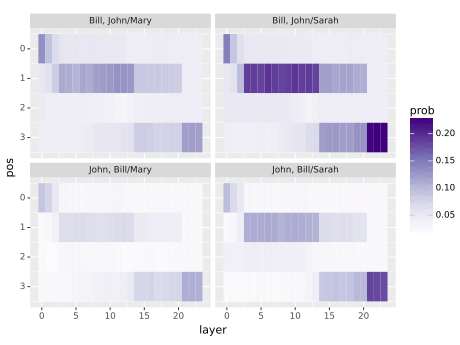

In [168]:
df = pd.DataFrame(data)
df["layer"] = df["layer"].astype(int)
df["pos"] = df["pos"].astype(int)
df["prob"] = df["prob"].astype(float)

plot = (ggplot(df[df["token"] == 1], aes(x="layer", y="pos")) + scale_y_reverse()
        + geom_tile(aes(fill="prob")) + scale_fill_cmap("Purples") + facet_wrap("intervention"))
print(plot)

In [172]:
data = []

for name1 in names["he"][:2]:
    for name2 in names["she"][:2]:
        tokens = tokenizer.encode(f" he she")
        base = tokenizer(f"{name1} amazed {name2} because", return_tensors="pt").to(device)
        sources = [tokenizer(f"{name1} hated {name2} because", return_tensors="pt").to(device)]
        print(tokenizer.decode(base.input_ids[0]))
        print(tokenizer.decode(sources[0].input_ids[0]))
        assert base.input_ids.shape == sources[0].input_ids.shape
        for layer_i in tqdm(range(gpt.config.num_hidden_layers)):
            for pos_i in range(4):
                alignable_config = simple_position_config(type(gpt), layer_i)
                alignable = AlignableModel(alignable_config, gpt)
                _, counterfactual_outputs = alignable(
                    base,
                    sources,
                    {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
                )
                probs = sm(counterfactual_outputs.logits)[0, -1].cpu().detach()
                for i, token in enumerate(tokens):
                    data.append({
                        "layer": layer_i,
                        "pos": pos_i,
                        "intervention": f"{name1}, {name2}",
                        "prob": probs[token].item(),
                        "token": i
                    })

John amazed Sarah because
John hated Sarah because


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.08it/s]


John amazed Mary because
John hated Mary because


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.07it/s]


Bill amazed Sarah because
Bill hated Sarah because


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.08it/s]


Bill amazed Mary because
Bill hated Mary because


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.08it/s]


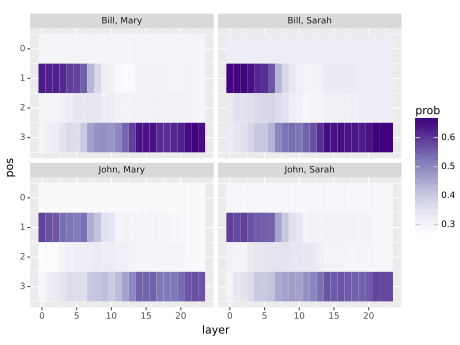

In [175]:
df = pd.DataFrame(data)
df["layer"] = df["layer"].astype(int)
df["pos"] = df["pos"].astype(int)
df["prob"] = df["prob"].astype(float)

plot = (ggplot(df[df["token"] == 1], aes(x="layer", y="pos")) + scale_y_reverse()
        + geom_tile(aes(fill="prob")) + scale_fill_cmap("Purples") + facet_wrap("intervention"))
print(plot)